# Detección de Anomalías con ESD sobre los residuos

## 1. Carga de residuos ARIMA y SES

In [5]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
# Estilo para los respectivos gráficos
plt.style.use("seaborn-v0_8")

# Cargar residuos ARIMA y SES
ruta_res_arima = "../data/processed/residuos_arima.csv"
ruta_res_ses = "../data/processed/residuos_ses.csv"

res_arima = pd.read_csv(ruta_res_arima, index_col=0, parse_dates=True)
res_ses = pd.read_csv(ruta_res_ses, index_col=0, parse_dates=True)

# Verificar estructura básica 
print("Residuos ARIMA:")
print(res_arima.head())
print(res_arima.info(), "\n")

print("Residuos SES:")
print(res_ses.head())
print(res_ses.info(), "\n")

# Unificar en un solo DataFrame (solo intersección temporal)
df_residuos = res_arima.join(res_ses, how="inner")
print("DataFrame combinado de residuos:")
print(df_residuos.head())
print(df_residuos.info())

Residuos ARIMA:
                     residuos_arima
timestamp                          
2017-07-07 03:30:00    32582.631607
2017-07-07 03:31:00     8883.956299
2017-07-07 03:32:00    -9303.322093
2017-07-07 03:33:00     7369.328132
2017-07-07 03:34:00    -2227.471084
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   residuos_arima  93 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None 

Residuos SES:
                     residuos_ses
timestamp                        
2017-07-07 03:30:00  20712.884079
2017-07-07 03:31:00  -1241.532249
2017-07-07 03:32:00 -24506.580012
2017-07-07 03:33:00  -5382.662931
2017-07-07 03:34:00  -9302.438547
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Data columns (total 1 columns):
 #   Column       

## 2. Inspección visual rápida de los residuos

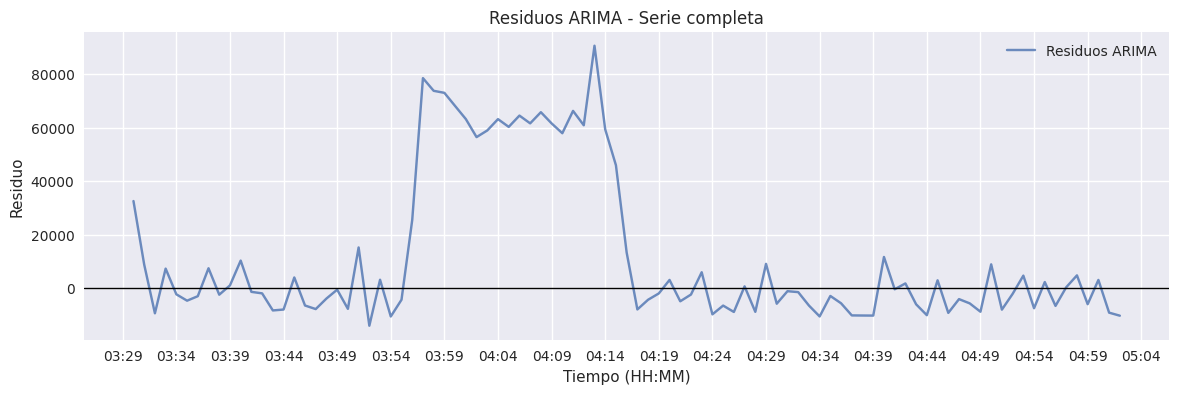

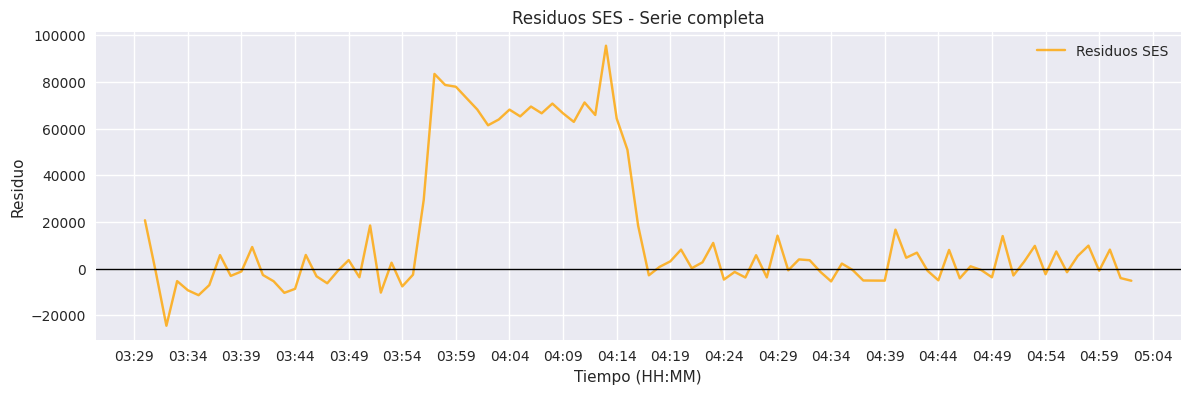

In [6]:
# Residuos ARIMA
plt.figure(figsize=(14,4))
plt.plot(df_residuos.index, df_residuos["residuos_arima"], label="Residuos ARIMA", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuos ARIMA - Serie completa")
plt.xlabel("Tiempo (HH:MM)")
# Formato para dejar cada intervalo de 5 minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel("Residuo")
plt.grid(True)
plt.legend()
plt.show()

# Residuos SES
plt.figure(figsize=(14,4))
plt.plot(df_residuos.index, df_residuos["residuos_ses"], label="Residuos SES", color="orange", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuos SES - Serie completa")
plt.xlabel("Tiempo (HH:MM)")
# Formato para dejar cada intervalo de 5 minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel("Residuo")
plt.grid(True)
plt.legend()
plt.show()

## 3. Implementación de prueba estadística ESD

In [7]:
def esd_test(series, alpha, max_outliers):
    # Remover NaN y convertir a arreglo
    serie_limpia = series.dropna()
    x = serie_limpia.values.astype(float)
    idx_original = serie_limpia.index

    print("===== INICIO ESD =====")
    print("Tamaño inicial de la serie (n):", len(x))
    print("alpha:", alpha, "max_outliers:", max_outliers)
    print("----------------------")

    n_inicial = len(x)
    if n_inicial < 10:
        raise ValueError("Muy pocos datos para aplicar ESD (Rosner recomienda n >= 10).")

    # Índices internos relativos a la serie limpia
    indices_restantes = np.arange(n_inicial)

    registros_iteraciones = []
    anomalías = []

    # Iterar según el máximo número de outliers permitido
    for i in range(1, max_outliers + 1):

        N = len(x)  # tamaño ACTUAL de la muestra restante
        print(f"\nIteración {i} - tamaño actual N:", N)

        if N <= 2:
            print("N <= 2, deteniendo ESD.")
            break

        mu = np.mean(x)
        sigma = np.std(x, ddof=1)
        print("  media (mu):", mu)
        print("  desviación estándar (sigma):", sigma)

        if sigma == 0:
            print("  sigma = 0, no se puede continuar.")
            break

        # Calcular estadístico R_i
        R_i = np.abs((x - mu) / sigma)
        max_R = np.max(R_i)
        pos_R = np.argmax(R_i)
        valor_max = x[pos_R]

        print("  max_R:", max_R)
        print("  valor en max_R:", valor_max)

        # Cálculo de p, t_crit y lambda_i usando N actual
        p = 1 - alpha / (2 * N)
        t_crit = stats.t.ppf(p, df=N - 2)
        lambda_i = ((N - 1) * t_crit) / np.sqrt((N - 2 + t_crit**2) * (N + 1))

        print("  p:", p)
        print("  t_crit:", t_crit)
        print("  lambda_i:", lambda_i)

        es_outlier = max_R > lambda_i
        print("  ¿max_R > lambda_i?:", es_outlier)

        registros_iteraciones.append({
            "iter": i,
            "N_actual": N,
            "R_i": max_R,
            "lambda_i": lambda_i,
            "es_outlier": es_outlier,
            "valor": valor_max,
            "pos_original": indices_restantes[pos_R],
            "timestamp": idx_original[indices_restantes[pos_R]]
        })

        if es_outlier:
            anomalías.append(indices_restantes[pos_R])
            # Eliminar este punto y seguir
            x = np.delete(x, pos_R)
            indices_restantes = np.delete(indices_restantes, pos_R)
        else:
            print("  No se detectan más outliers. Se detiene el algoritmo.")
            break

    print("\n===== FIN ESD =====")
    resultados = pd.DataFrame(registros_iteraciones)
    if resultados.empty:
        print("No se registró ninguna iteración en ESD.")
    else:
        print("Iteraciones registradas:")
        print(resultados)

    resultados_outliers = resultados[resultados["es_outlier"] == True].copy()
    anomalías_timestamps = list(resultados_outliers["timestamp"])

    print("\nOutliers detectados (timestamps):", anomalías_timestamps)
    print("Cantidad de outliers:", len(anomalías_timestamps))

    return anomalías_timestamps, resultados_outliers

## 4. Aplicar ESD a los residuos ARIMA

### 4.1 Extraer la serie ARIMA 

In [8]:
# Extraer la serie de residuos ARIMA como pd.Series
res_arima_series = df_residuos["residuos_arima"]

print(type(res_arima_series))
print(res_arima_series.head())

<class 'pandas.core.series.Series'>
timestamp
2017-07-07 03:30:00    32582.631607
2017-07-07 03:31:00     8883.956299
2017-07-07 03:32:00    -9303.322093
2017-07-07 03:33:00     7369.328132
2017-07-07 03:34:00    -2227.471084
Name: residuos_arima, dtype: float64


### 4.2 Definir parámetros **alpha** y **max_outliers**

alpha = 0.05 --> Nivel de signfiicacncia clásico en estadística (5%)

max_outliers --> Basado en Rosner: entre 5% y 20% del tamaño muestral

In [9]:
n = len(res_arima_series)
max_outliers = max(1, int(0.1*n)) #Tomamos el 10% como valor intermedio

print("Tamaño de la serie de residuos ARIMA:", n)
print("max_outliers elegido:", max_outliers)

Tamaño de la serie de residuos ARIMA: 93
max_outliers elegido: 9


### 4.3 Aplicar ESD a los residuos de ARIMA

In [10]:
alpha = 0.05 #Nivel de significancia

anomalia_arima_indice, anomalia_arima_df = esd_test(res_arima_series,alpha=alpha, max_outliers=max_outliers)

print("Cantidad de anomalías detectadas en Residuos ARIMA:", len(anomalia_arima_indice))
anomalia_arima_df = anomalia_arima_df.sort_values("timestamp")
anomalia_arima_df.head()

===== INICIO ESD =====
Tamaño inicial de la serie (n): 93
alpha: 0.05 max_outliers: 9
----------------------

Iteración 1 - tamaño actual N: 93
  media (mu): 11951.659672698685
  desviación estándar (sigma): 28203.37892422964
  max_R: 2.787218231740896
  valor en max_R: 90560.63160700849
  p: 0.999731182795699
  t_crit: 3.5887702736723437
  lambda_i: 3.3412202944024156
  ¿max_R > lambda_i?: False
  No se detectan más outliers. Se detiene el algoritmo.

===== FIN ESD =====
Iteraciones registradas:
   iter  N_actual       R_i  lambda_i  es_outlier         valor  pos_original  \
0     1        93  2.787218   3.34122       False  90560.631607            43   

            timestamp  
0 2017-07-07 04:13:00  

Outliers detectados (timestamps): []
Cantidad de outliers: 0
Cantidad de anomalías detectadas en Residuos ARIMA: 0


,iter,N_actual,R_i,lambda_i,es_outlier,valor,pos_original,timestamp


## 5. Aplicar ESD a los residuos SES

### 5.1 Extraer la serie SES

In [11]:
# Extraer la serie de residuos SES como pd.Series
res_ses_series = df_residuos["residuos_ses"]

print(type(res_ses_series))
print(res_ses_series.head())

<class 'pandas.core.series.Series'>
timestamp
2017-07-07 03:30:00    20712.884079
2017-07-07 03:31:00    -1241.532249
2017-07-07 03:32:00   -24506.580012
2017-07-07 03:33:00    -5382.662931
2017-07-07 03:34:00    -9302.438547
Name: residuos_ses, dtype: float64


### 5.2 Definir parámetros alpha y max_outliers

alpha = 0.05 --> Nivel de signfiicacncia clásico en estadística (5%)

max_outliers --> Basado en Rosner: entre 5% y 20% del tamaño muestral

In [12]:
n = len(res_ses_series)
max_outliers = max(1, int(0.1*n)) #Tomamos el 10% como valor intermedio

print("Tamaño de la serie de residuos SES:", n)
print("max_outliers elegido:", max_outliers)

Tamaño de la serie de residuos SES: 93
max_outliers elegido: 9


### 5.3 Aplicar ESD a los residuos de SES

In [13]:
alpha = 0.05 #Nivel de significancia

anomalia_ses_indice, anomalia_ses_df = esd_test(res_ses_series,alpha=alpha, max_outliers=max_outliers)

print("Cantidad de anomalías detectadas en Residuos SES:", len(anomalia_ses_indice))
anomalia_ses_df = anomalia_ses_df.sort_values("timestamp")
anomalia_ses_df.head()

===== INICIO ESD =====
Tamaño inicial de la serie (n): 93
alpha: 0.05 max_outliers: 9
----------------------

Iteración 1 - tamaño actual N: 93
  media (mu): 14947.49039478443
  desviación estándar (sigma): 29180.969910300922
  max_R: 2.761889954039497
  valor en max_R: 95542.1180391734
  p: 0.999731182795699
  t_crit: 3.5887702736723437
  lambda_i: 3.3412202944024156
  ¿max_R > lambda_i?: False
  No se detectan más outliers. Se detiene el algoritmo.

===== FIN ESD =====
Iteraciones registradas:
   iter  N_actual      R_i  lambda_i  es_outlier         valor  pos_original  \
0     1        93  2.76189   3.34122       False  95542.118039            43   

            timestamp  
0 2017-07-07 04:13:00  

Outliers detectados (timestamps): []
Cantidad de outliers: 0
Cantidad de anomalías detectadas en Residuos SES: 0


,iter,N_actual,R_i,lambda_i,es_outlier,valor,pos_original,timestamp


## 6. Construir residuo relativo 

In [14]:
# Cargar prediccion SES, serie temporal con total_pkts
ruta_serie = "../data/processed/serie_preparada.csv"
ruta_pred_ses = "../data/processed/prediccion_ses.csv"

serie_full = pd.read_csv(ruta_serie, index_col=0, parse_dates=True)
pred_ses = pd.read_csv(ruta_pred_ses, index_col=0, parse_dates=True)

Convertir serie_full y pred_ses de pandas.core.frame.DataFrame a pandas.core.series.Series

In [15]:
# --- Arreglar serie_full ---
print("serie_full type:", type(serie_full))
print("serie_full columnas:", getattr(serie_full, "columns", None))

if isinstance(serie_full, pd.DataFrame):
    if serie_full.shape[1] == 1:
        # Solo una columna -> la convertimos a Serie
        serie_full = serie_full.iloc[:, 0]
        serie_full.name = "total_pkts"
    else:
        raise ValueError("serie_full tiene varias columnas. Debes elegir cuál es total_pkts.")

print("Nuevo tipo serie_full:", type(serie_full))


# --- Arreglar pred_ses ---
print("pred_ses type:", type(pred_ses))
print("pred_ses columnas:", getattr(pred_ses, "columns", None))

if isinstance(pred_ses, pd.DataFrame):
    if pred_ses.shape[1] == 1:
        pred_ses_series = pred_ses.iloc[:, 0]
    else:
        # Si tu DataFrame de predicciones tiene una columna llamada 'prediccion_ses', la usamos
        if "prediccion_ses" in pred_ses.columns:
            pred_ses_series = pred_ses["prediccion_ses"]
        else:
            raise ValueError("pred_ses tiene varias columnas y no sé cuál es la predicción SES. Revisa columnas.")
else:
    pred_ses_series = pred_ses  # ya es Serie

pred_ses = pred_ses_series
pred_ses.name = "prediccion_ses"

print("Nuevo tipo pred_ses:", type(pred_ses))
print("Head serie_full:\n", serie_full.head())
print("Head pred_ses:\n", pred_ses.head())
print("Head res_ses_series:\n", res_ses_series.head())


serie_full type: <class 'pandas.core.frame.DataFrame'>
serie_full columnas: Index(['total_pkts'], dtype='object')
Nuevo tipo serie_full: <class 'pandas.core.series.Series'>
pred_ses type: <class 'pandas.core.frame.DataFrame'>
pred_ses columnas: Index(['prediccion_ses'], dtype='object')
Nuevo tipo pred_ses: <class 'pandas.core.series.Series'>
Head serie_full:
 timestamp
2017-07-07 03:30:00    43583
2017-07-07 03:31:00    27517
2017-07-07 03:32:00     3899
2017-07-07 03:33:00    16056
2017-07-07 03:34:00    10606
Name: total_pkts, dtype: int64
Head pred_ses:
 timestamp
2017-07-07 03:30:00    22870.115921
2017-07-07 03:31:00    28758.532249
2017-07-07 03:32:00    28405.580012
2017-07-07 03:33:00    21438.662931
2017-07-07 03:34:00    19908.438547
Name: prediccion_ses, dtype: float64
Head res_ses_series:
 timestamp
2017-07-07 03:30:00    20712.884079
2017-07-07 03:31:00    -1241.532249
2017-07-07 03:32:00   -24506.580012
2017-07-07 03:33:00    -5382.662931
2017-07-07 03:34:00    -9302.4385

In [16]:
#Las series son:
#    serie_full --> Serie temporal de los paquetes por minuto con el indice de timestamp
#    pred_ses --> Serie temporal de la predicción del modelo entrenado SES
#    res_ses_series --> Serie temporal de los residuos del modelo SES

# Construir residuo relativo: r_t = e_t / ŷ_t
epsilon = 1e-6
residuo_rel_ses = res_ses_series / (pred_ses + epsilon)
residuo_rel_ses.name = "residuo_rel_ses"

print("Primeros valores residuo_rel_ses:")
print(residuo_rel_ses.head())
print("¿Hay NaN en residuo_rel_ses?:", residuo_rel_ses.isna().any())

Primeros valores residuo_rel_ses:
timestamp
2017-07-07 03:30:00    0.905675
2017-07-07 03:31:00   -0.043171
2017-07-07 03:32:00   -0.862738
2017-07-07 03:33:00   -0.251073
2017-07-07 03:34:00   -0.467261
Name: residuo_rel_ses, dtype: float64
¿Hay NaN en residuo_rel_ses?: False


Gráfico exportado exitosamente a:  ../results/19_residuo_relativo_ses.png


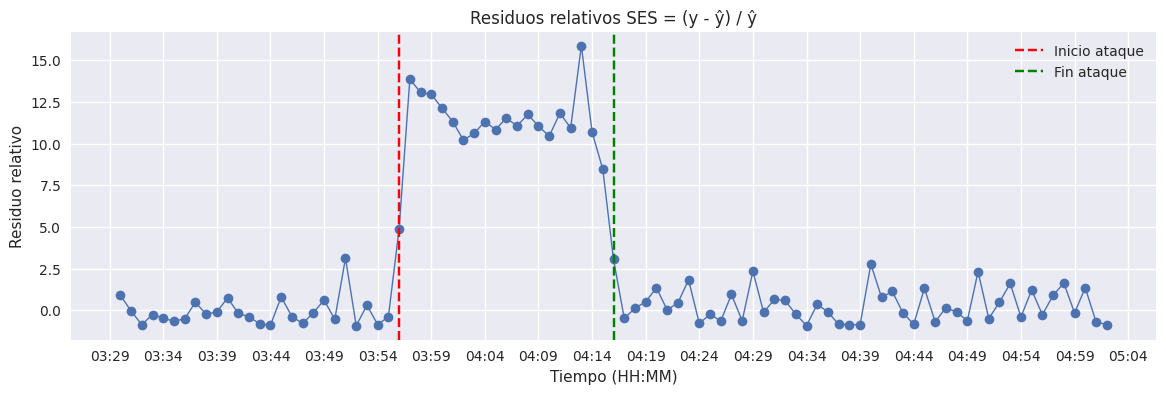

In [19]:
# Visualización del residuo relativo
plt.figure(figsize=(14,4))
plt.plot(residuo_rel_ses, marker="o", linewidth=1)
plt.axvline(pd.to_datetime("2017-07-07 03:56:00"), color="red", linestyle="--", label="Inicio ataque")
plt.axvline(pd.to_datetime("2017-07-07 04:16:00"), color="green", linestyle="--", label="Fin ataque")
plt.title("Residuos relativos SES = (y - ŷ) / ŷ")
plt.xlabel("Tiempo (HH:MM)")
# Formato para dejar cada intervalo de 5 minutos
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel("Residuo")
plt.ylabel("Residuo relativo")
plt.grid(True)
plt.legend()
ruta = "../results/19_residuo_relativo_ses.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

In [20]:
# Parámetros ESD
alpha = 0.05

# Usamos, por ejemplo, 10% de n como número máximo de outliers (dentro del rango 5–20% que sugiere Rosner)
n = len(residuo_rel_ses.dropna())
max_outliers = max(1, int(0.1 * n))

print("n =", n, "   max_outliers =", max_outliers)

anom_ses_idx, anom_ses_df = esd_test(
    residuo_rel_ses,
    alpha=alpha,
    max_outliers=max_outliers
)

print("Cantidad de anomalías detectadas con ESD sobre residuo relativo SES:", len(anom_ses_idx))
anom_ses_df = anom_ses_df.sort_values("timestamp")
anom_ses_df.head(10)


n = 93    max_outliers = 9
===== INICIO ESD =====
Tamaño inicial de la serie (n): 93
alpha: 0.05 max_outliers: 9
----------------------

Iteración 1 - tamaño actual N: 93
  media (mu): 2.5632328817620924
  desviación estándar (sigma): 4.754897697397707
  max_R: 2.799323933379479
  valor en max_R: 15.87373180685847
  p: 0.999731182795699
  t_crit: 3.5887702736723437
  lambda_i: 3.3412202944024156
  ¿max_R > lambda_i?: False
  No se detectan más outliers. Se detiene el algoritmo.

===== FIN ESD =====
Iteraciones registradas:
   iter  N_actual       R_i  lambda_i  es_outlier      valor  pos_original  \
0     1        93  2.799324   3.34122       False  15.873732            43   

            timestamp  
0 2017-07-07 04:13:00  

Outliers detectados (timestamps): []
Cantidad de outliers: 0
Cantidad de anomalías detectadas con ESD sobre residuo relativo SES: 0


,iter,N_actual,R_i,lambda_i,es_outlier,valor,pos_original,timestamp
